In [1]:
import jax 
import jax.numpy as jnp
from jax.random import normal
import numpy as np
import pandas as pd
from IPython.display import display


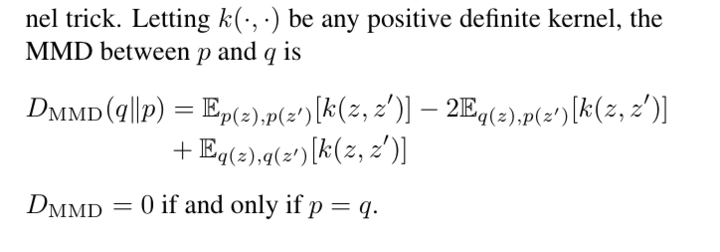

In [2]:
def mmd(u1, u2, v1, v2, k):
    """
    u1, u2: N_u * d array where each row is a sample from pdf p(.)
    v1, v2: N_v * d array where each row is a sample from pdf q(.)
    k: kernel function that measures similarity of u / v
    """
    uu = jnp.mean(k(u1, u2))
    uv = jnp.mean(k(u1+u2, v1+v2))
    vv = jnp.mean(k(v1, v2))
    return uu + vv - 2*uv

In [3]:
def gaussian_kernel(u, v, s=1.):
    norm = jnp.linalg.norm(u-v, axis=1)
    return jnp.exp(-norm/(2*s**2))
    

In [4]:
def mmd_estimator_stats(batch_size=32, 
                        feature_dim=8, 
                        dm=0.1,
                        n_trials=10000,
                        seed=42,
                        kernel=gaussian_kernel):
    
    rng_key = jax.random.PRNGKey(seed)
    
    m1 = 0
    m2 = m1 + dm
    s1 = 1
    s2 = 1
    d = feature_dim
    N = batch_size
    shape = (N, d)
    
    mmd_estimates = []
    
    @jax.jit
    def aux(rng_key, i):
        *keys, rng_key = jax.random.split(rng_key, 5)
        u1 = s1*normal(keys[0], shape) + m1
        u2 = s1*normal(keys[1], shape) + m1
        v1 = s1*normal(keys[2], shape) + m2
        v2 = s1*normal(keys[3], shape) + m2
        return mmd(u1, u2, v1, v2, kernel), rng_key
    
    for i in range(n_trials):
        res, rng_key = aux(rng_key, i)
        mmd_estimates.append(res)
        
    mmd_mean = np.mean(mmd_estimates)
    mmd_std = np.std(mmd_estimates)
    return mmd_mean, mmd_std

In [9]:
def experiment(batch_size_lst=[16, 32, 64, 128],
               m_diff_lst=[1e-2, 1e-1, 1e0, 1e1],
               feature_dim_lst=[8, 16, 32, 64]):
    dfs = {}
    for batch_size in batch_size_lst:
        res_arr = np.empty((len(m_diff_lst), len(feature_dim_lst)), dtype=tuple)
        for i, m_diff in enumerate(m_diff_lst):
            for j, feature_dim in enumerate(feature_dim_lst):
                res_arr[i,j] = mmd_estimator_stats(batch_size=batch_size, 
                                                   dm=m_diff, 
                                                   feature_dim=feature_dim)
                
        df = pd.DataFrame(res_arr, 
                          pd.MultiIndex.from_product([['Difference in means'], m_diff_lst]),
                          pd.MultiIndex.from_product([['Number of feature dimensions'], feature_dim_lst]))
        dfs[batch_size] = df
        print(f"Batch size: {batch_size}")
        display(df.style.format(lambda ms: f"{ms[0]:.3} ({ms[1]:.3})" ))
        
    return dfs
                
        

In [10]:
dfs = experiment()

Batch size: 16


Batch size: 32


Batch size: 64


Batch size: 128
